In [44]:
import pandas as pd
import numpy as np
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

In [30]:
# Specify experiment name prefix (if there are multiple possibilities, this script will grab one that was last modified).
exp_name_prefix = 'medium-run'

In [87]:
# Concatenate the outputs into one big dataframe.
exp_dirs = glob.glob('../exps/results/%s*' % exp_name_prefix)
exp_dirs.sort(key=os.path.getmtime)
latest_exp_dir = exp_dirs[-1]

mini_out_csvs = glob.glob(latest_exp_dir + '/out*.csv')
mini_out_dfs = list(map(lambda p: pd.read_csv(p, index_col=0), mini_out_csvs))
big_out = pd.concat(mini_out_dfs)

# Truncate off some precision and convert to string so we have a consistent label.
big_out['epsilon_label'] = np.array(map(lambda f: "%.3f" % f, big_out['epsilon_tolerance']))
big_out['delta_label'] = np.array(map(lambda f: "%.3f" % f, big_out['delta_clearance']))

# compute mc results
mc_results = big_out.pivot_table(columns=['epsilon_tolerance',
                                          'delta_clearance',
                                          'dim',
                                          'n_samples',
                                          'delta_label',
                                          'epsilon_label'], values='ed_complete').melt(
    value_name='est_prob_ed_complete')

# compute theoretical results too. start with the number of samples required from the bound, and then increase regularly.
vol_unit_ball = np.pi ** (mc_results['dim'] / 2) / scipy.special.gamma(mc_results['dim'] / 2 + 1)
measure_unit_ball = (
        vol_unit_ball /
        (
                (2 * mc_results['delta_clearance'] + 1)
                * (2 * mc_results['delta_clearance']) ** (mc_results['dim'] - 1)
        )
)
rho = measure_unit_ball * (
        mc_results['epsilon_tolerance'] * mc_results['delta_clearance']
        / np.sqrt(1 + mc_results['delta_clearance'] ** 2)
) ** mc_results['dim']

prob_in_gamma_regime = 1 - 2 * np.exp(-mc_results['n_samples'] * rho / 4)
not_in_gamma_regime = mc_results['n_samples'] < 8 * (mc_results['dim'] + 1) / rho * np.log(13 / rho)
prob_in_gamma_regime[not_in_gamma_regime] = np.NaN
mc_results['th_prob_ed_complete'] = prob_in_gamma_regime
mc_results = mc_results.drop(columns=['delta_clearance', 'epsilon_tolerance'])
mc_results = mc_results.melt(
    id_vars=['epsilon_label', 'delta_label', 'n_samples', 'dim'],
    var_name='est_or_th',
    value_name='prob_ed_complete'
).dropna()

<Figure size 1600x1700 with 0 Axes>

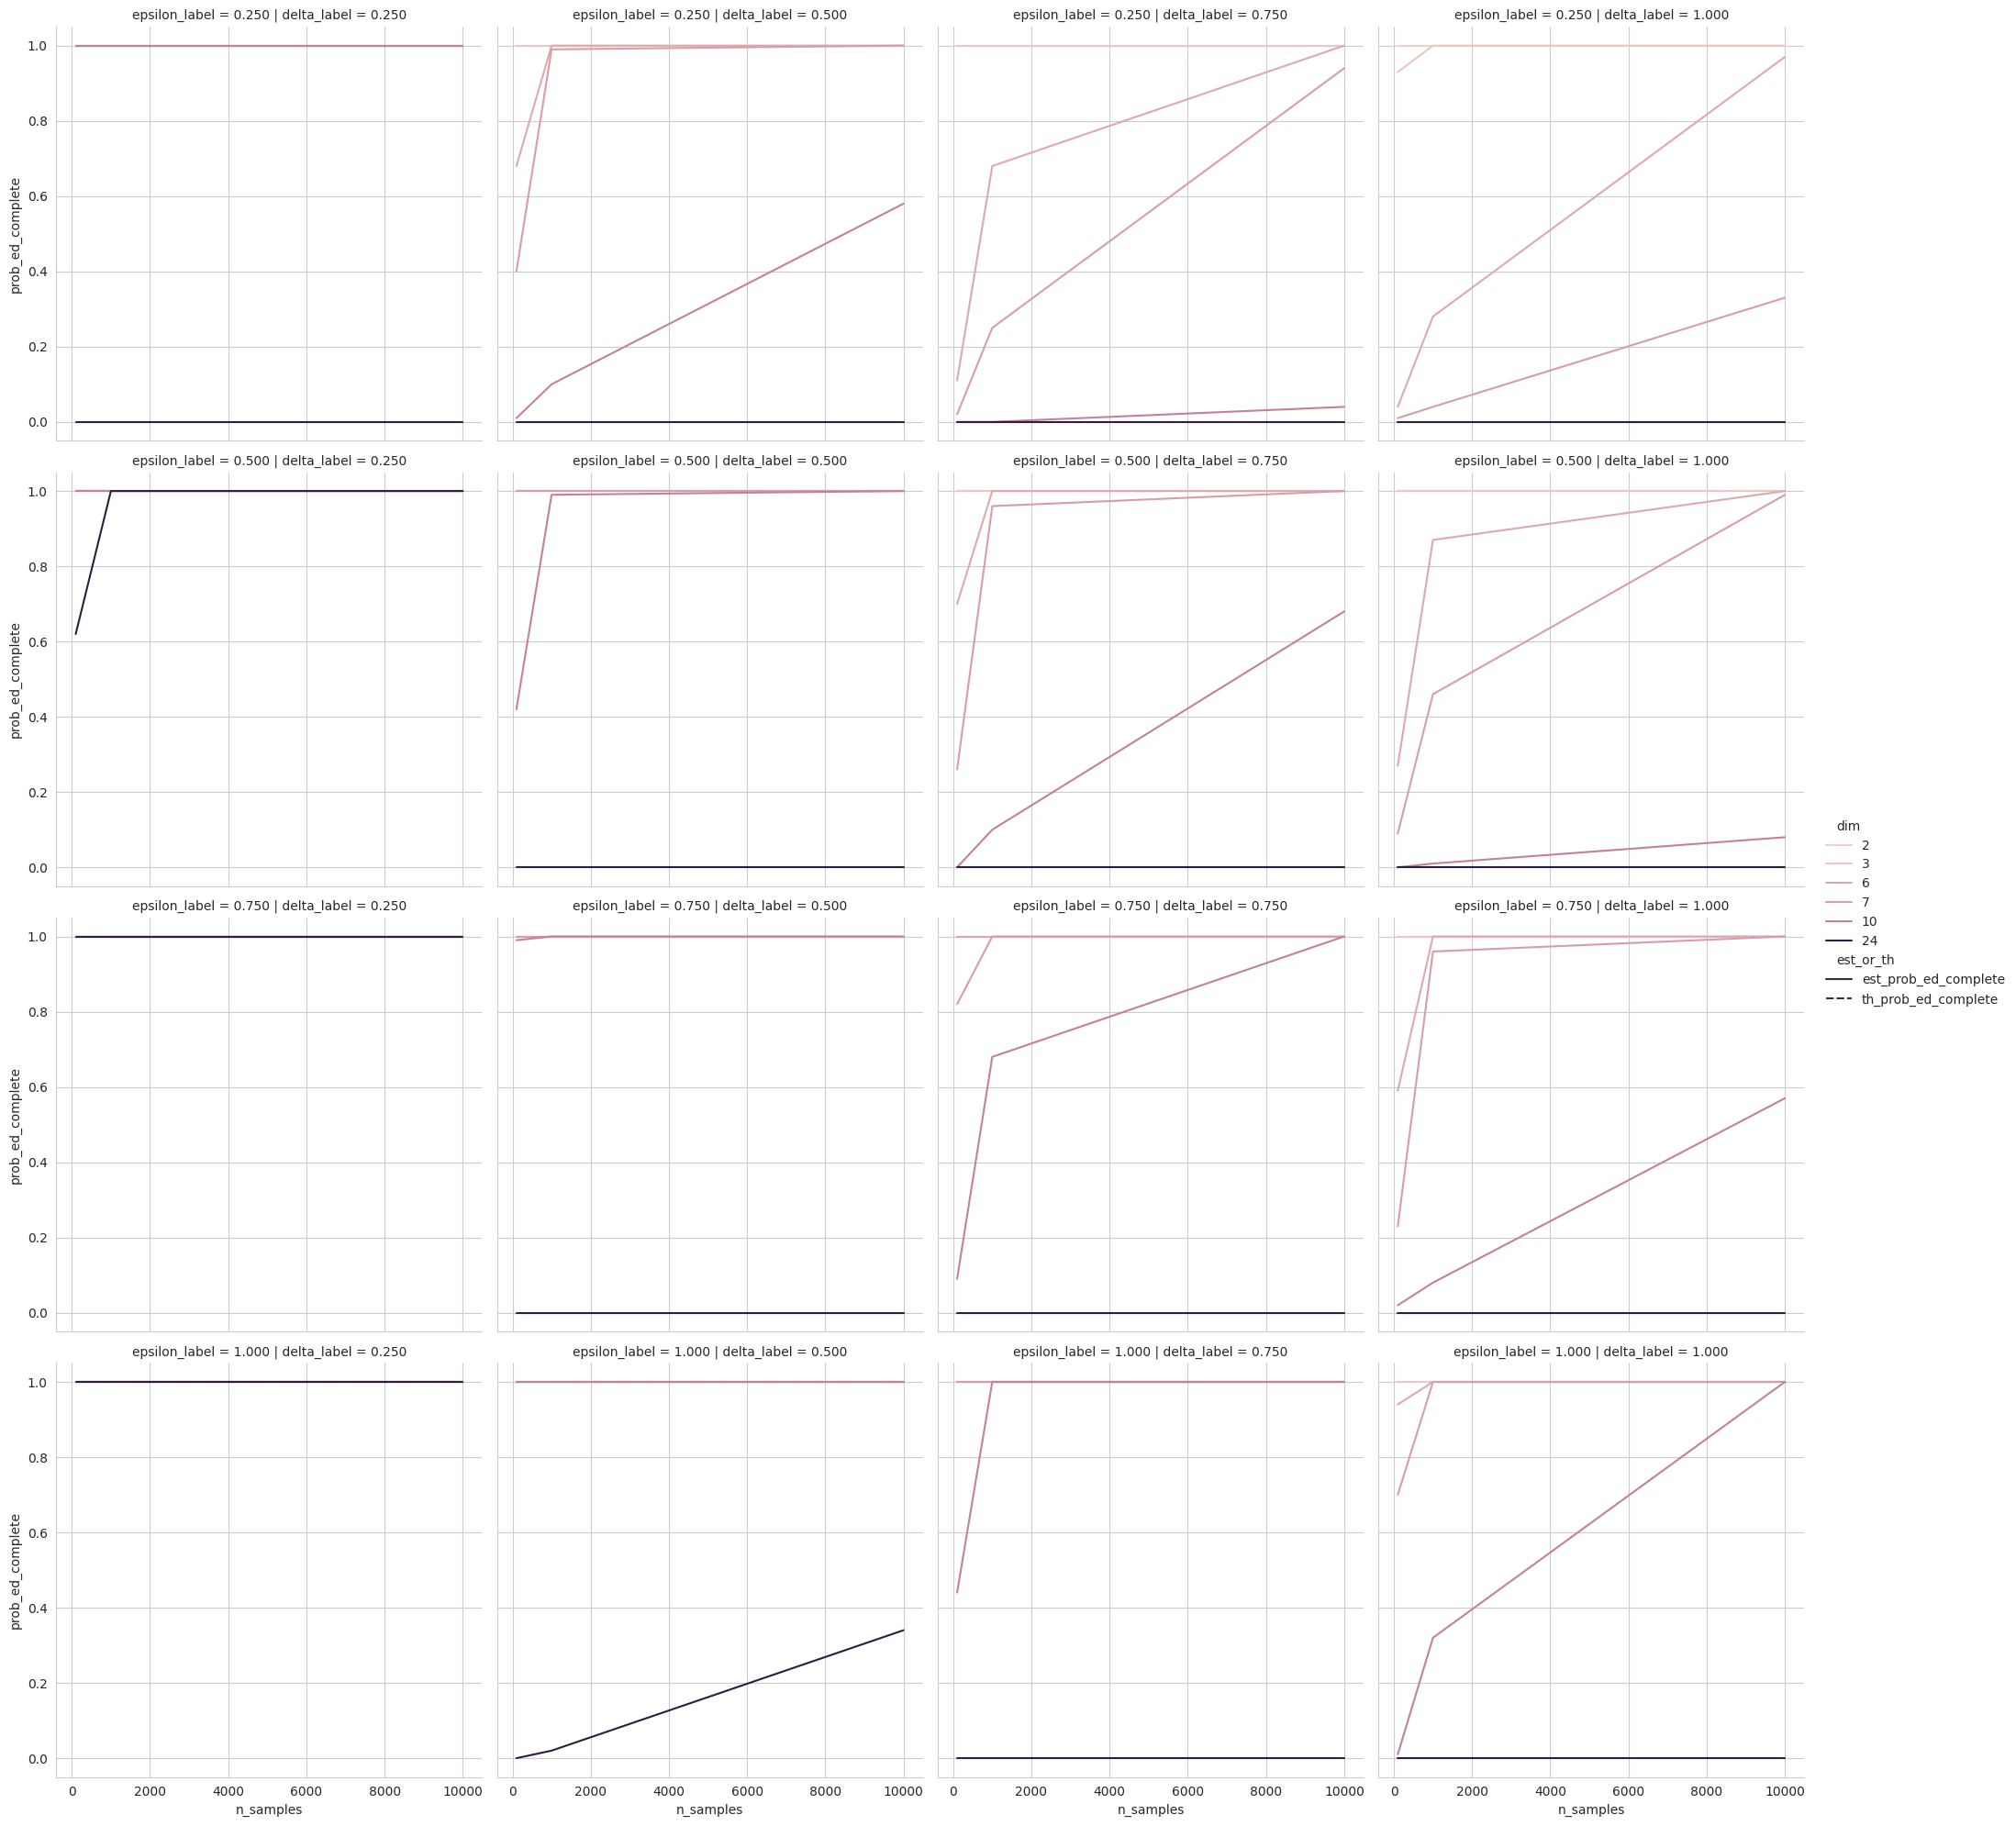

In [85]:
# Plot the monte-carlo rate against the number of samples taken. 
# The data is already in long-form, and readily consumable by seaborn.
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=(16, 17))
sns.relplot(data=mc_results, x='n_samples', y='prob_ed_complete',
            row='epsilon_label', col='delta_label', 
            hue='dim', style='est_or_th',
            kind='line')
plt.show()